In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import seaborn as sns

%matplotlib inline

## read in the data

In [2]:
data = pd.read_csv('youtube-comments.csv')

In [3]:
data.head()

,comment,troll,title,views,dislikes,commentCount,likes,replies,id
0,"What a lucky guy, got celebrated birthday on c...",0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
1,Love it﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
2,no americans even knew who corden was several ...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
3,my birthday was the 22nd as well and we both s...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
4,OMG IM CRYING﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w


## cleaning the text

In [4]:
def cleaner(text):
    '''Function to clean the text data and prep for further analysis'''
    stops = set(stopwords.words("english"))     # Creating a set of Stopwords
    p_stemmer = PorterStemmer()                 # Creating the stemmer model
    text = re.sub("[^a-zA-Z]"," ",text)          # Removes punctuation
    text = text.split()                          # Splits the data into individual words 
    text = [w for w in text if not w in stops]   # Removes stopwords
    text = [p_stemmer.stem(i) for i in text]     # Stemming (reducing words to their root)
    return ' '.join(text)

In [5]:
data['clean'] = data['comment'].apply(cleaner)

In [6]:
data.head()

,comment,troll,title,views,dislikes,commentCount,likes,replies,id,clean
0,"What a lucky guy, got celebrated birthday on c...",0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,What lucki guy got celebr birthday concert bil...
1,Love it﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,Love
2,no americans even knew who corden was several ...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,american even knew corden sever year ago
3,my birthday was the 22nd as well and we both s...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,birthday nd well support west ham
4,OMG IM CRYING﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,OMG IM CRi


## using tf-idf to convert the clean comments to a matrix of freq's

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

In [8]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X = vectorizer.fit_transform(data.clean)

## creating labels

In [9]:
le = preprocessing.LabelEncoder()
le.fit(data.troll.values)
Y = le.transform(data.troll.values) 

## defining a classifier function

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def model_rfc(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.80)
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    clf_probs = np.dot(clf.predict_proba(X_test)>0.5, np.array([0, 1]))
    score = confusion_matrix(y_test, clf_probs)
    print('confidence matrix:')
    print(score)
    plt.bar(range(X.shape[1]), clf.feature_importances_)
    
    return np.dot(clf.predict_proba(X)>0.5, np.array([0, 1]))

## dimensionality reduction

tf-idf vectorizer gives around 5500 words (columns) and that's more than the number of rows, and since most words are redundant anyway it is important to reduce the dimensionality of the problem

### trying PCA

In [11]:
from sklearn import decomposition

In [12]:
%%time

pca = decomposition.PCA(n_components=100)
pca.fit(X.toarray())
#data_pca = pca.transform(X)

Wall time: 2.41 s


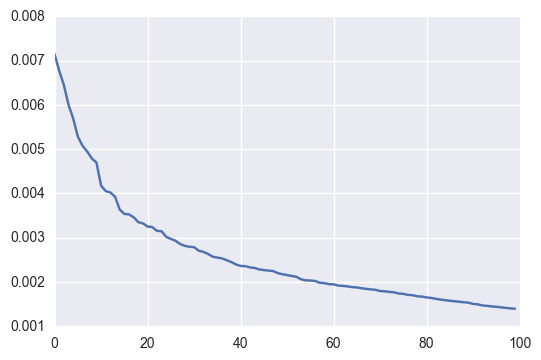

In [13]:
plt.plot(pca.explained_variance_ratio_)

In [14]:
%%time

pca = decomposition.PCA(n_components=20)
pca.fit(X.toarray())
X_pca = pca.transform(X.toarray())

Wall time: 1.89 s


## classifying using the result of PCA

confidence matrix:
[[691  20]
 [ 56  20]]


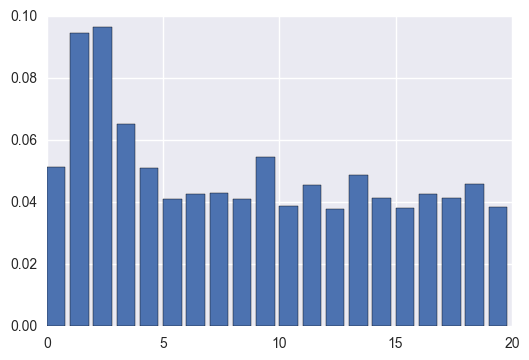

In [98]:
clf_probs = model_rfc(X_pca, Y)

False positives

In [112]:
data['comment'][(clf_probs==1) & (data.troll==0)]

72                      He&#39;s fucking amazing !!!!!!!﻿
197      i have Celiac&#39;s disease, this fucking sucks﻿
221                     The modern era is a fucking joke﻿
269     So Murder and Theft are okay? Lets start the f...
354                            whooooooooopie fucking do﻿
435                                                  wtf﻿
584     why does this shit keep getting recommended to...
766                                                  wtf﻿
1533                           this is fucking hilarious﻿
1767                               he looks like zoom!!!﻿
1931                                        What a shame﻿
1973                                          Holy shit!﻿
2320    What&#39;s wrong with imigrants ur fucking cou...
2574                      ahahah Scots ate fucking funny﻿
2622                             That&#39;s fucking rank﻿
2640                               what the fuck is that﻿
2644    AHAHA that&#39;s a wee baby mate this is funny...
2660          

False negatives

In [113]:
data['comment'][(clf_probs==0) & (data.troll==1)]

94           James cordens stylist 😂 fucking state of it﻿
229     6 months? ...fuck that. At least give people a...
339     this nigga was the cause of my dad getting &qu...
772     how is this on trending cause that is what mos...
831                           dafuck is this. no just no﻿
832     Miley completely and utterly destroyed a classic﻿
836     They all suck they should take notes from Jaco...
923     looks like shes shes still useing milk bleach ...
948     Wouldn&#39;t it be great if that yacht fell th...
951     wtf is this, why is this news... tmz is n cancer﻿
959              So fat and stiff looking, actual whelp.﻿
1104                                       yeah my nigga﻿
1135                    just came here to see the boobs😍﻿
1153    this bitch clearly lying through her teeth she...
1171    Dang, Vlad stop interviewing this heffa. She n...
1282                                                lame﻿
1378                               Nate is piece of shit﻿
1538          

## creating new features based on the length of the comment etc

In [16]:
def bad_word_counter(text):
    bad_words = pd.read_csv('google_badlist.txt', header=None).values
    return len([w for w in text.split() if w in bad_words])

In [17]:
def transform(documents):
    ## some handcrafted features!
    n_words = [len(c.split()) for c in documents]
    n_chars = [len(c) for c in documents]
    # number of uppercase words
    allcaps = [np.sum([w.isupper() for w in comment.split()])
           for comment in documents]
    # longest word
    max_word_len = [np.max([len(w) for w in c.split()]) for c in documents]
    # average word length
    mean_word_len = [np.mean([len(w) for w in c.split()])
                                        for c in documents]
    # number of google badwords:
    n_bad = [bad_word_counter(c) for c in documents]
    exclamation = [c.count("!") for c in documents]
    addressing = [c.count("@") for c in documents]
    spaces = [c.count(" ") for c in documents]

    allcaps_ratio = np.array(allcaps) / np.array(n_words, dtype=np.float)
    bad_ratio = np.array(n_bad) / np.array(n_words, dtype=np.float)

    return np.array([n_words, n_chars, allcaps, max_word_len,
        mean_word_len, exclamation, addressing, spaces,
        allcaps_ratio, n_bad, bad_ratio]).T

## classifying based on the features like the length of the comment etc

In [18]:
from sklearn.preprocessing import scale

confidence matrix:
[[683  29]
 [ 64  11]]


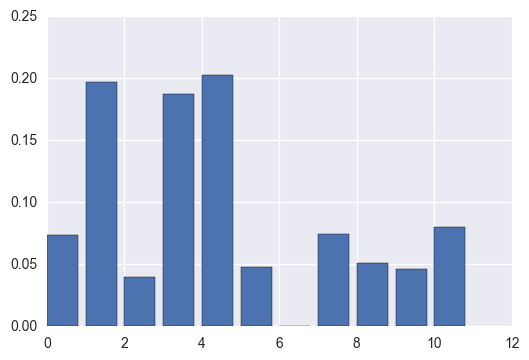

In [114]:
X_ext = scale(transform(data.comment), with_mean=True, axis=0)
clf_probs = model_rfc(X_ext, Y)

False negatives

In [115]:
data['comment'][(clf_probs==0) & (data.troll==1)]

84                                 What a bunch of cunts﻿
94           James cordens stylist 😂 fucking state of it﻿
257     Don&#39;t agree with the gluten free one. Fuck...
307                                        cheating scum﻿
308                                               nigger﻿
331       was that good for a blackman chucking a spear?﻿
380                                   Well that was shit﻿
592     Why is this kind of stuff on YouTube. It&#39;s...
703                                               Cancer﻿
738                                    how is this funny﻿
740                                     waste of my time﻿
744                                 what the actual fuck﻿
772     how is this on trending cause that is what mos...
777                                           goofy fuck﻿
778           Why are you saying that your face is gross﻿
785                                          Wtf is this﻿
831                           dafuck is this. no just no﻿
832     Miley 

False positives

In [116]:
data['comment'][(clf_probs==1) & (data.troll==0)]

3       my birthday was the 22nd as well and we both s...
24                           Guy is so fucking hot &lt;3﻿
38                              I WAS THERE AT THAT TIME﻿
118                      That green looked damn good tho﻿
221                     The modern era is a fucking joke﻿
303          Did anyone actually care about the olypics?﻿
360     how the hell does he expect to catch his food ...
395     Ohohohoho Taken reversed and holy hell it look...
404                                              Jason!!﻿
414                           This movie looks terrible.﻿
621                        Aww this gave me such fuzzies﻿
884                          never can beat the original﻿
985                                        Beyonce queen﻿
1206    This scene was pretty damn dank but why is it ...
1225                                    Trending anyone?﻿
1305                                     Excuses excuses﻿
1376    dude is straight smoking weed in the interview...
1549          

## classifying based on generated features

In [79]:
np.concatenate((X_pca, transform(data.comment)),axis=1).mean(axis=0)

array([ -1.07281736e-17,   6.20819399e-18,   4.32292209e-18,
         9.63576071e-19,  -4.55921479e-18,  -4.58346124e-18,
        -1.93777650e-17,  -5.14910618e-18,  -8.11154052e-18,
         1.91998842e-18,   3.12459627e-18,   8.89613369e-18,
        -3.73437251e-17,  -4.44084801e-18,  -7.21089502e-18,
        -9.24010268e-19,   6.04640402e-18,   4.07891460e-18,
        -1.06100273e-18,  -6.77974901e-18,   1.42706480e+01,
         8.15804320e+01,   7.73824651e-01,   1.09529860e+01,
         5.13713604e+00,   4.73951715e-01,   2.28716645e-03,
         1.37062262e+01,   6.74682535e-02,   1.24777637e-01,
         1.12531335e-02])

confidence matrix:
[[700  14]
 [ 57  16]]


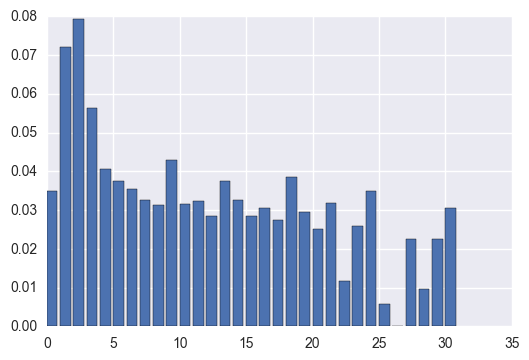

In [117]:
clf_probs = model_rfc(np.concatenate((X_pca, transform(data.comment)), axis=1), Y)

False positives

In [118]:
data['comment'][(clf_probs==1) & (data.troll==0)]

72                      He&#39;s fucking amazing !!!!!!!﻿
197      i have Celiac&#39;s disease, this fucking sucks﻿
995     I thought this would be some next &quot; how t...
1166                                  stank pussy ass ho﻿
1287    this dude always complaining tho diaz fan for ...
1848    Those guards are probably thinking &quot;what ...
2210      Religion in general just needs to fucking stop﻿
2574                      ahahah Scots ate fucking funny﻿
2670    &quot;Stinks o fucking shite&quot;. Quote of t...
2913    tell me this how do u get in the bed with devi...
3118    iPhone 7 will fuck the shit out of that lagdro...
3234                     Fuck what? your TV? oh alright~﻿
3331    oh my god, he&#39;s so EVIL! fucking kill your...
3457                   ARE YOU FUCKING KIDDING ME BROCK?﻿
Name: comment, dtype: object

False negatives

In [119]:
data['comment'][(clf_probs==0) & (data.troll==1)]

84                                 What a bunch of cunts﻿
259                  kys college humor you&#39;re cancer﻿
307                                        cheating scum﻿
308                                               nigger﻿
339     this nigga was the cause of my dad getting &qu...
772     how is this on trending cause that is what mos...
895     I hope that bitch drowns, that black lives mat...
935                           everyone at t mz are cunts﻿
937       Shows like this are the cancer of the Internet﻿
942     Imagine being stuck in a room with all those c...
948     Wouldn&#39;t it be great if that yacht fell th...
956     Milking the fuck outta videos!! They just keep...
958                                   she looks very fat﻿
967                                               fat af﻿
1092                            WHO IS THIS BITCH ?! =))﻿
1094                CERTIFIED HOE. HOLD THIS L FOR LIFE.﻿
1104                                       yeah my nigga﻿
1143    Bruh. 

## visualizing some of the features

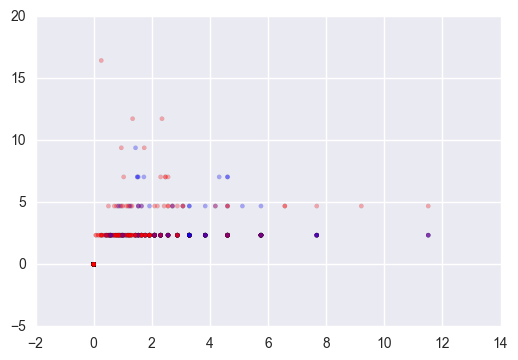

In [21]:
colors = ['r', 'b']
label_colors = [colors[lab] for lab in data.troll.values]

plt.scatter(X_ext[:,-1], X_ext[:,-2], 
            s=10,
            lw=0.1,
            c=label_colors,
            alpha=0.3)

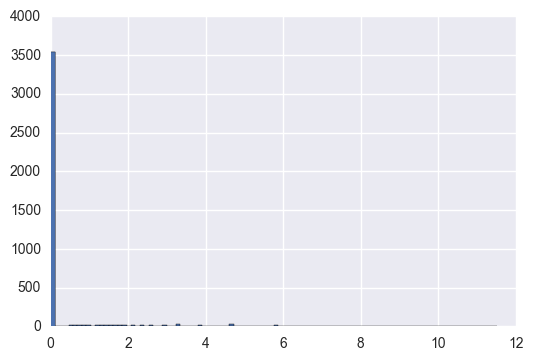

In [22]:
a = plt.hist(X_ext[:,-1], bins=100)

the fact that only 10% of the data is trolls means that maybe an anamoly detection approach would perform better

## using isolation forest

In [51]:
from sklearn.ensemble import IsolationForest

def model_ifc(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.80)
    clf = IsolationForest(n_estimators=100)
    clf.fit(X_train, y_train)
    clf_probs = clf.predict(X_test) < 0
    score = confusion_matrix(y_test, clf_probs)
    print(score)

In [52]:
model_ifc(X_pca, Y)

[[643  65]
 [ 74   5]]
